# Convolutional neural networks

Computer vision is different from generic classificatio, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific pattern and their combinations. 
To extract patterns we will use convolutional filters. 

In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from utils import *
train_loader, test_loader, train_set, test_set = load_mnist(64)

# Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

They are defined by matrices of weight coefficients.

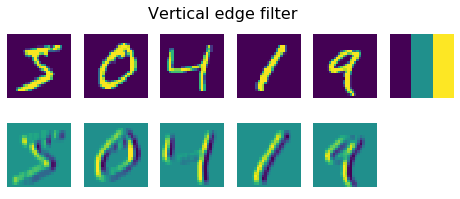

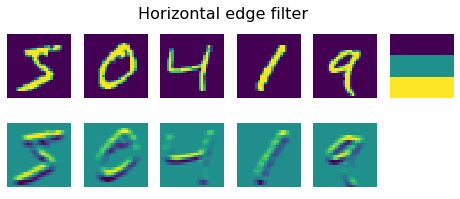

In [3]:
def plot_convolution(t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = train_set[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        plt.show()

plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.

To do that, we introduce **convolutional layers**.

# Convolutional layers

Convolutiona layers are defined using `nn.Conv2d`. We need to specify the following:
`in_channels` - number of input channels. We are dealing with grayscale images, so it is 1.
`out_channels` - number of output channels. It is the number of filters we want to apply.
`kernel_size` - size of the filter. It is the number of pixels in the filter. Its usually 3x3 or 5x5.

Simplest CNN will contain one convolutional layer.

Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24.

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use relu activation function in between layers.

In [4]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184, 10)
    
    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x

net = OneConv()
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Epoch  0, Train acc=0.958, Val acc=0.979, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.981, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.985, Val acc=0.980, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.982, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.978, Train loss=0.001, Val loss=0.002


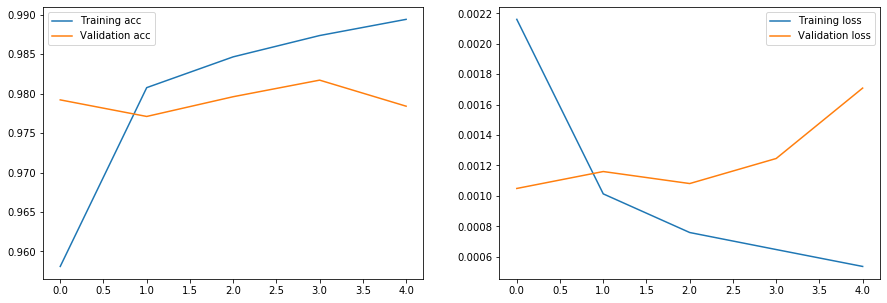

In [5]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

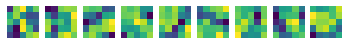

In [6]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

# Multi-layered CNN and pooling layers

First convolutional layers looks for primitive patterns, such as horizontal or vertical lines, but we can apply further convolutional layers to find more complex patterns. Then more convolutional layers can combine those shape into some parts of the picture, up to the point where we can classify the image.

When doing so, we may also apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within sliding 3x3 window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the pooling layers:

Average Pooling takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
Max Pooling replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.
Thus, in a typical CNN there would be several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.
![](https://docs.microsoft.com/en-us/learn/modules/intro-computer-vision-pytorch/images/cnn-pyramid.png)

Because of decreasing spatial dimentions and increasing features/filters dimensions, this architecture is called **pyramid architecture**.

In [7]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10,20,5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x

net = MultiLayerCNN()
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Flatten: 1-5                           [1, 320]                  --
├─Linear: 1-6                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [8]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.943, Val acc=0.969, Train loss=0.003, Val loss=0.002
Epoch  1, Train acc=0.975, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.977, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.979, Val acc=0.982, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.979, Val acc=0.975, Train loss=0.001, Val loss=0.001


# CIFAR-10 DATASETS

In [9]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 14, shuffle= False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
            'house', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


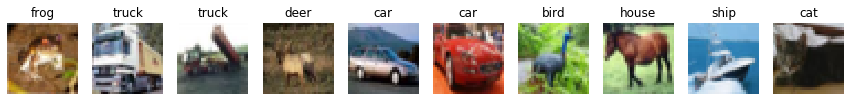

In [10]:
display_dataset(trainset, classes = classes)

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(120, 64)
        self.output = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

net = LeNet()
summary(net, input_size = (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [12]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.273, Val acc=0.416, Train loss=0.140, Val loss=0.114
Epoch  1, Train acc=0.455, Val acc=0.493, Train loss=0.107, Val loss=0.100
Epoch  2, Train acc=0.523, Val acc=0.535, Train loss=0.095, Val loss=0.093
